# setup

In [1]:
import networkx as nx

import os

import math
import statistics
import numpy as np
from scipy import stats as st

from time import perf_counter
from tqdm import trange, tqdm

import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

In [3]:
def avg(Ns):
    return math.fsum(Ns) / len(Ns)

def neutrality(G, path, agg):
    Ns = []
    for u,v in zip(path, path[1:]):
        Ns.append(G.edges[u,v]['weight'])
    return agg(Ns)

In [4]:
def saw_yang_mo(s_neut, ybar, stdev, r):
    diff = abs(s_neut - ybar)
    
    if diff == 0:
        return 1
    elif stdev == 0:
        return 1/r
    else:
        lam = (diff / math.sqrt((r+1)/r)) / stdev
        return min(1, 1/lam**2 + 1/r)

### read data

In [5]:
Gs = {}
with os.scandir("data/graphs") as directory:
    for entry in directory:
        if entry.is_file():
            source_id = entry.name[0]
            Gs[source_id] = nx.read_weighted_edgelist(entry.path, nodetype=int)

### define constants

In [6]:
n = len(next(iter(Gs.values())).nodes)
s = tuple(range(n))
# print(f"number of possible orderings: {math.factorial(n)}")

timeit_iterations = 5  # 5 is the standard in the timeit module

r_domain = range(10, 500, 20)
r_fixed = 1000

# experiments

### relative neutrality

In [7]:
# source_rel_neuts = {}
# for source, G in Gs.items():
#     rel_neuts = []
#     for agg in (avg, min):
#         neuts = []
#         for i in range(r_fixed):
#             p = rng.permutation(n)
#             neuts.append(neutrality(G, p, agg))
#         s_neut = neutrality(G, s, agg)
#         ybar = statistics.fmean(neuts)
#         rel_neuts.append((s_neut, ybar))
#     source_rel_neuts[source] = rel_neuts

# for source, results in source_results_final.items():
#     print(f"source {source}")
#     rel_avg = results[0][0] / results[0][1]
#     rel_min = results[1][0] / results[1][1]
#     print(f"avg aggregation: neutrality of given ordering = {results[0][0]}")
#     print(f"sample mean of neutrality = {results[0][1]}")
#     print(f"relative neutrality: {rel_avg}")
#     print(f"min aggregation: neutrality of given ordering = {results[1][0]}")
#     print(f"sample mean of neutrality = {results[1][1]}")
#     print(f"relative neutrality: {rel_min}")
#     print()

### cherry-picking

In [8]:
source_results_final = {}
for source, G in Gs.items():
    probs = []
    for agg in (avg, min):
        neuts = []
        for i in range(r_fixed):
            p = rng.permutation(n)
            neuts.append(neutrality(G, p, agg))
        s_neut = neutrality(G, s, agg)
        ybar = statistics.fmean(neuts)
        stdev = statistics.stdev(neuts, ybar)
        probs.append(saw_yang_mo(s_neut, ybar, stdev, r_fixed))
    source_results_final[source] = probs

In [9]:
for source, results in source_results_final.items():
    print(f"SOURCE {source}")
    for i, agg in enumerate(("avg", "min")):
        print(f"Under {agg} aggregation, the probability that a random ordering \
would have neutrality at least as high as that of s is bounded by {results[i]}.")
    print()

SOURCE a
Under avg aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.
Under min aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.

SOURCE c
Under avg aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.
Under min aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.

SOURCE f
Under avg aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.
Under min aggregation, the probability that a random ordering would have neutrality at least as high as that of s is bounded by 1.



## plots

In [26]:
source_results = {}
for source, G in Gs.items():
    probs = []
    times = []
    for r in tqdm(r_domain):
        inner_probs = []
        inner_times = []
        for agg in (avg, min):
            time_min = math.inf
            for _ in range(timeit_iterations):
                start = perf_counter()
                neuts = []
                for i in range(r):
                    p = rng.permutation(n)
                    neuts.append(neutrality(G, p, agg))
                s_neut = neutrality(G, s, agg)
                ybar = statistics.fmean(neuts)
                stdev = statistics.stdev(neuts, ybar)

                # upper bound on the probability of a random ordering having neutrality `s_neut`
                prob = saw_yang_mo(s_neut, ybar, stdev, r)
                
                time_min = min(time_min, perf_counter() - start)
            inner_probs.append(prob)
            inner_times.append(time_min)
        probs.append(inner_probs)
        times.append(inner_times)
    source_results[source] = (probs, times)

100%|████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.53it/s]


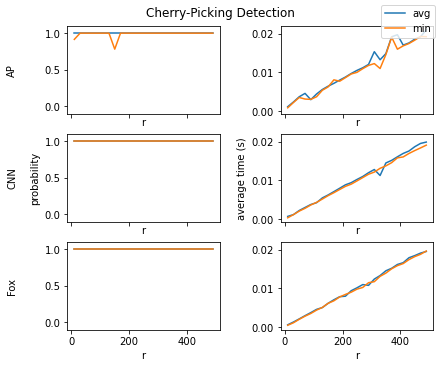

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(6,5), sharex=True, sharey='col', constrained_layout=True)
fig.suptitle('Cherry-Picking Detection')

for i, (source, (probs, times)) in enumerate(source_results.items()):
    lines = axes[i, 0].plot(r_domain, probs, label=["avg", "min"])
    axes[i, 0].set_xlabel('r')
    axes[i, 0].set_ybound(-0.1, 1.1)

    axes[i, 1].plot(r_domain, times)
    axes[i, 1].set_xlabel('r')

axes[0, 0].set_ylabel('AP\n\n')
axes[1, 0].set_ylabel('CNN\n\nprobability')
axes[2, 0].set_ylabel('Fox\n\n')
axes[1, 1].set_ylabel('\naverage time (s)')

fig.legend(handles=lines)

plt.savefig("plots/detection_plots.png")